In [72]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.express as px
from IPython.display import HTML, Javascript
from IPython.display import display
from IPython.display import IFrame
from flask import Markup
from IPython.display import Image
import plotly
import plotly.express as px
from IPython.display import clear_output
import plotly.graph_objects as go
%matplotlib inline
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import warnings
warnings.filterwarnings('ignore')

In [73]:
df_eval = pd.read_csv('./eval_df.csv', index_col=0)
df_eval.head()

,IMSI_hashed,BRAND,DEVICE_MANUFACTURER_TXT,MUNICIPALITY_NM,PROVINCE_STATE_CD,TENURE_DAY_QTY_SCALED,PRICE_PLAN,PROD_TV,SEGMENT_NM,LOCALITY_NM,LIFESTAGE,THREE_MONTH_AVG_WLN_BILLING_SCALED,THREE_MONTH_AVG_WLS_BILLING_SCALED,BAN_hashed,PROD_INTERNET,Score
4024,906660042404286,T,apple,VANCOUVER,BC,0.361143,L&R ULNW 6GB shareable data,1,Unclassified,Unassigned,Unassigned,0.036612,0.064822,69593775,1,0.667636
5165,906661637105175,T,samsung,PEACHLAND,BC,0.520429,L&R ULNW 6GB shareable data,1,Down to Earth,Lower-Middle Rural,Older Families & Empty Nests,0.028046,0.035066,3920613,1,0.713431
5437,906660105115566,T,apple,EDMONTON,AB,0.230857,YourChoice L&R Premium 70 - Unlimited nationwi...,1,Juggling Acts,Younger Urban Mix,Younger Singles & Couples,0.036271,0.151685,40594509,0,0.376904
7470,906660125028681,T,apple,PRINCE GEORGE,BC,0.001714,"Unlimited 30 - Unlimited nationwide talk, text...",1,Just Getting By,Younger Urban Mix,Younger Singles & Couples,0.023693,0.158718,116353437,1,0.197703
5174,906660950867097,K,apple,VIKING,AB,0.056286,$50 12GB UL min Plan SFD,0,Down to Earth,Lower-Middle Rural,Older Families & Empty Nests,0.018258,0.033996,108765771,1,0.954711


In [74]:
df_eval['bins'] = pd.qcut(df_eval.Score.rank(method='first',ascending = False),10,labels=range(10))
df_eval['pred'] = np.where(df_eval['bins']<3, 1, 0)
df_eval.head()

,IMSI_hashed,BRAND,DEVICE_MANUFACTURER_TXT,MUNICIPALITY_NM,PROVINCE_STATE_CD,TENURE_DAY_QTY_SCALED,PRICE_PLAN,PROD_TV,SEGMENT_NM,LOCALITY_NM,LIFESTAGE,THREE_MONTH_AVG_WLN_BILLING_SCALED,THREE_MONTH_AVG_WLS_BILLING_SCALED,BAN_hashed,PROD_INTERNET,Score,bins,pred
4024,906660042404286,T,apple,VANCOUVER,BC,0.361143,L&R ULNW 6GB shareable data,1,Unclassified,Unassigned,Unassigned,0.036612,0.064822,69593775,1,0.667636,4,0
5165,906661637105175,T,samsung,PEACHLAND,BC,0.520429,L&R ULNW 6GB shareable data,1,Down to Earth,Lower-Middle Rural,Older Families & Empty Nests,0.028046,0.035066,3920613,1,0.713431,4,0
5437,906660105115566,T,apple,EDMONTON,AB,0.230857,YourChoice L&R Premium 70 - Unlimited nationwi...,1,Juggling Acts,Younger Urban Mix,Younger Singles & Couples,0.036271,0.151685,40594509,0,0.376904,7,0
7470,906660125028681,T,apple,PRINCE GEORGE,BC,0.001714,"Unlimited 30 - Unlimited nationwide talk, text...",1,Just Getting By,Younger Urban Mix,Younger Singles & Couples,0.023693,0.158718,116353437,1,0.197703,9,0
5174,906660950867097,K,apple,VIKING,AB,0.056286,$50 12GB UL min Plan SFD,0,Down to Earth,Lower-Middle Rural,Older Families & Empty Nests,0.018258,0.033996,108765771,1,0.954711,1,1


In [75]:
cust_conf = df_eval[["IMSI_hashed", "BAN_hashed", "PROD_INTERNET", "pred"]]
cust_conf['TP'] = np.where((cust_conf.PROD_INTERNET==1) & (cust_conf.pred ==1), 1, 0)
cust_conf['FP'] = np.where((cust_conf.pred==1) & (cust_conf.PROD_INTERNET ==0), 1, 0)
cust_conf['TN'] = np.where((cust_conf.PROD_INTERNET==0) & (cust_conf.pred ==0), 1, 0)
cust_conf['FN'] = np.where((cust_conf.pred==0) & (cust_conf.PROD_INTERNET==1), 1, 0)
cust_conf.columns = ['IMSI','BAN','Actual','Predict', "TP","FP","TN","FN"]

In [76]:
print("TP:", cust_conf.TP.sum())
print('FP:',cust_conf.FP.sum())
print('TN:',cust_conf.TN.sum())
print('FN:', cust_conf.FN.sum())

TP: 1088
FP: 26
TN: 1388
FN: 1210


## Model Evaluation

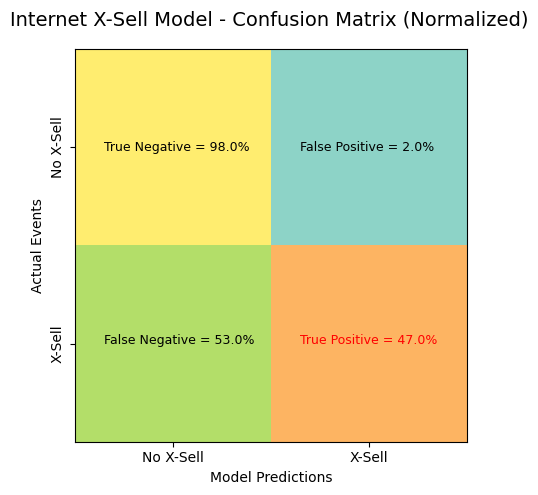

In [77]:
plt.subplots(figsize=(6,5))
plt.suptitle('Internet X-Sell Model - Confusion Matrix (Normalized)',fontsize=14)
results = confusion_matrix(cust_conf.Actual, cust_conf.Predict)
results = (results.astype('float') / results.sum(axis=1)[:, np.newaxis]).round(2)
plt.imshow(results,interpolation= 'nearest',cmap=plt.cm.Set3)
classNames = ['No X-Sell', 'X-Sell']
plt.ylabel('Actual Events')
plt.xlabel('Model Predictions')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90, va="center")
s = [['True Negative','False Positive'], ['False Negative', 'True Positive']]

plt.text(-.35,.02, str(s[0][0])+" = "+str(results[0][0]*100)+"%",fontsize=9)
plt.text(.65,.02, str(s[0][1])+" = "+str(results[0][1]*100)+"%",fontsize=9)
plt.text(-.35,1, str(s[1][0])+" = "+str(results[1][0]*100)+"%",fontsize=9)
plt.text(.65,1, str(s[1][1])+" = "+str(results[1][1]*100)+"%",fontsize=9).set_color('red')
 
plt.tight_layout()
plt.show()

In [78]:
Train_Data1 = df_eval[['PROD_INTERNET','Score']]
Train_Data1['decile'] = pd.qcut(Train_Data1['Score'].rank(method='first', ascending = False), 10, labels=range(10))
Train_Data1.columns = ['Defaulter','Probability','Decile']
Train_Data1['Non-Defaulter'] = 1-Train_Data1['Defaulter']
Train_Data1.head()

,Defaulter,Probability,Decile,Non-Defaulter
4024,1,0.667636,4,0
5165,1,0.713431,4,0
5437,0,0.376904,7,1
7470,1,0.197703,9,0
5174,1,0.954711,1,0


In [79]:
df1 = pd.pivot_table(data=Train_Data1,index=['Decile'],values=['Defaulter','Non-Defaulter','Probability'],
                     aggfunc={'Defaulter':[np.sum],
                              'Non-Defaulter':[np.sum],
                              'Probability' : [np.min,np.max]})

df1.reset_index()
df1.columns = ['Defaulter_Count','Non-Defaulter_Count','max_score','min_score']
df1['Total_Cust'] = df1['Defaulter_Count']+df1['Non-Defaulter_Count']
df1['Default_Rate'] = (df1['Defaulter_Count'] / df1['Total_Cust']).apply('{0:.2%}'.format)
default_sum = df1['Defaulter_Count'].sum()
non_default_sum = df1['Non-Defaulter_Count'].sum()
df1['Default %'] = (df1['Defaulter_Count']/default_sum).apply('{0:.2%}'.format)
df1['Non_Default %'] = (df1['Non-Defaulter_Count']/non_default_sum).apply('{0:.2%}'.format)
df1['ks_stats'] = np.round(((df1['Defaulter_Count'] / df1['Defaulter_Count'].sum()).cumsum() -(df1['Non-Defaulter_Count'] / df1['Non-Defaulter_Count'].sum()).cumsum()), 4) * 100

flag = lambda x: '*****' if x == df1['ks_stats'].max() else ''
df1['max_ks'] = df1['ks_stats'].apply(flag)
df1

,Defaulter_Count,Non-Defaulter_Count,max_score,min_score,Total_Cust,Default_Rate,Default %,Non_Default %,ks_stats,max_ks
Decile,,,,,,,,,,
0,367,5,0.999992,0.957607,372,98.66%,15.97%,0.35%,15.62,
1,360,11,0.957599,0.925943,371,97.04%,15.67%,0.78%,30.50,
2,361,10,0.925867,0.886586,371,97.30%,15.71%,0.71%,45.51,
3,293,78,0.886511,0.752976,371,78.98%,12.75%,5.52%,52.74,*****
4,224,147,0.752704,0.614118,371,60.38%,9.75%,10.40%,52.09,
5,194,177,0.614104,0.508111,371,52.29%,8.44%,12.52%,48.02,
6,160,211,0.507961,0.418040,371,43.13%,6.96%,14.92%,40.06,
7,141,230,0.417998,0.333449,371,38.01%,6.14%,16.27%,29.93,
8,108,263,0.333039,0.244866,371,29.11%,4.70%,18.60%,16.03,


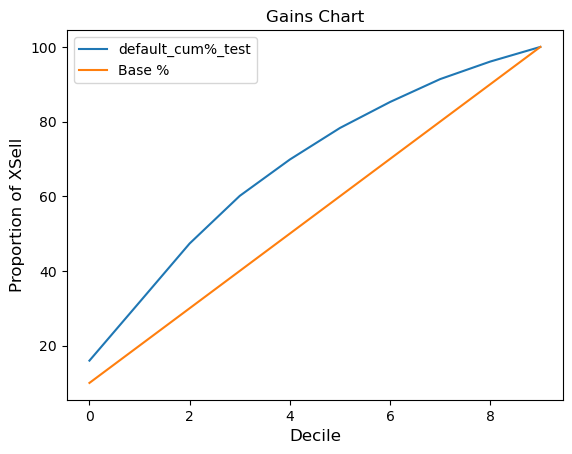

In [80]:
df1['default_cum%'] = np.round(((df1['Defaulter_Count'] / df1['Defaulter_Count'].sum()).cumsum()), 4) * 100
gains = df1[['default_cum%']]
gains.columns = ['default_cum%_test']
gains['Base %'] = range(10,110,10)

gains_chart = gains.plot(kind='line',use_index=False)
gains_chart.set_ylabel("Proportion of XSell",fontsize=12)
gains_chart.set_xlabel("Decile",fontsize=12)
gains_chart.set_title("Gains Chart")
plt.show()

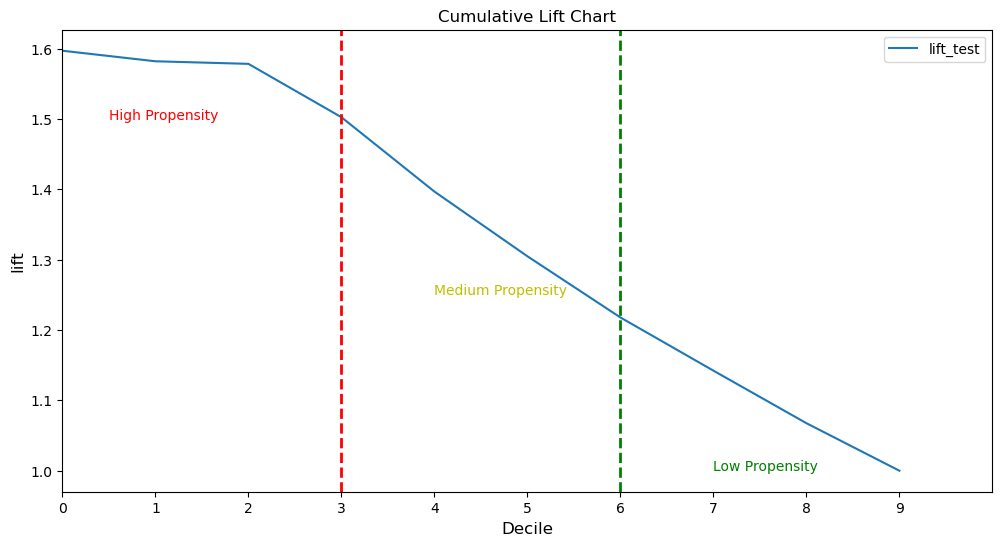

In [81]:
final2 = gains.copy()
final2['lift_test'] = (gains['default_cum%_test']/gains['Base %'])
final2['Baseline']  = ['1'] *10
lift_chart = final2[['lift_test','Baseline']]

lift_chart1 = lift_chart.plot(kind='line',use_index=False, figsize=(12, 6))
lift_chart1.set_ylabel("lift",fontsize=12)
lift_chart1.set_xlabel("Decile",fontsize=12)
lift_chart1.set_title("Cumulative Lift Chart")
plt.xlim([0, 10])
plt.xticks(np.arange(0, 10, 1))
plt.axvline(x= 3, color = 'r',linestyle='dashed', linewidth=2)
plt.axvline(x= 6, color = 'g',linestyle='dashed', linewidth=2)
plt.text(.5, 1.50, 'High Propensity',color = 'r')
plt.text(4, 1.25, 'Medium Propensity',color = 'y')
plt.text(7, 1, 'Low Propensity',color = 'g')
plt.show()

In [82]:
print("TP:", cust_conf.TP.sum())
print('FP:',cust_conf.FP.sum())
print('TN:',cust_conf.TN.sum())
print('FN:', cust_conf.FN.sum())

TP: 1088
FP: 26
TN: 1388
FN: 1210


## Campaign Strategy

In [83]:
df1 = df_eval[df_eval.bins < 3]
cust_conf_2 = df1[["IMSI_hashed", "BAN_hashed", "PROD_INTERNET", "pred"]]
cust_conf_2['TP'] = np.where((df1.PROD_INTERNET==1) & (df1.pred ==1), 1, 0)
cust_conf_2['FP'] = np.where((df1.pred==1) & (df1.PROD_INTERNET != df1.pred), 1, 0)
cust_conf_2['TN'] = np.where((df1.PROD_INTERNET==0) & (df1.pred ==0), 1, 0)
cust_conf_2['FN'] = np.where((df1.pred==0) & (df1.PROD_INTERNET!= df1.pred), 1, 0)
cust_conf_2.columns = ['IMSI','BAN','Actual','Predict', "TP","FP","TN","FN"]


print("TP:", cust_conf_2.TP.sum())
print('FP:',cust_conf_2.FP.sum())
print('TN:',cust_conf_2.TN.sum())
print('FN:', cust_conf_2.FN.sum())

TP: 1088
FP: 26
TN: 0
FN: 0


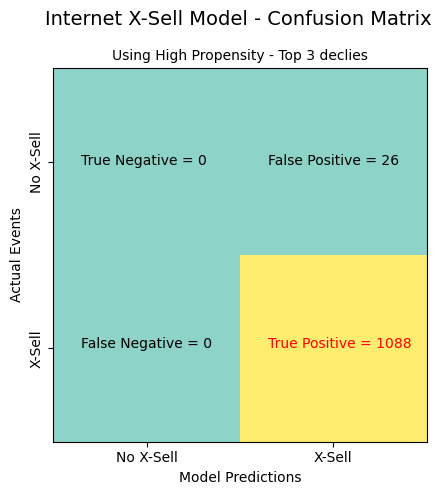

In [84]:
plt.subplots(figsize=(6,5))
plt.suptitle('Internet X-Sell Model - Confusion Matrix',fontsize=14)
plt.title('Using High Propensity - Top 3 declies',fontsize=10)
results = confusion_matrix(cust_conf_2.Actual, cust_conf_2.Predict)
plt.imshow(results,interpolation= 'nearest',cmap=plt.cm.Set3)
classNames = ['No X-Sell', 'X-Sell']
plt.ylabel('Actual Events')
plt.xlabel('Model Predictions')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90, va="center")
s = [['True Negative','False Positive'], ['False Negative', 'True Positive']]

plt.text(-.35,.02, str(s[0][0])+" = "+str(results[0][0]),fontsize=10)
plt.text(.65,.02, str(s[0][1])+" = "+str(results[0][1]),fontsize=10)
plt.text(-.35,1, str(s[1][0])+" = "+str(results[1][0]),fontsize=10)
plt.text(.65,1, str(s[1][1])+" = "+str(results[1][1]),fontsize=10).set_color('red')
 
plt.tight_layout()
plt.show()

In [85]:
rgu = 55
campaign_cost = 5
target = 1114
total_cost = target * 5
total_rev = 1088 * rgu
profit = total_rev - total_cost
print("Cost of campaign targeting Top 3 deciles is  $%.2f" %total_cost)
print("Revenue from campaign targeting Top 3 deciles is $%.2f" %profit)


Cost of campaign targeting Top 3 deciles is  $5570.00
Revenue from campaign targeting Top 3 deciles is $54270.00
